In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

In [3]:
df = pd.read_csv(r'C:\Users\fanchang\fan_python\FGEO_G601_01\FGEO_G601_01_phase_03_out.csv')
df.head()

,Station,sn,Operator,Phase,imx520.reprojection_error_mean,ov7251_slave.optical_center_y,ov7251_master.position_z,ov7251_master.position_y,ov7251_master.position_x,ov7251_master.reprojection_error_mean,...,ov7251_master.radial_distortion_k3,ov7251_slave.optical_center_x,ov7251_slave.position_x,imx520.pose_z,imx520.pose_x,imx520.radial_distortion_k2,ov7251_slave.pose_y,ov7251_master.radial_distortion_k2,IRtoIR.yaw,ov7251_master.focal_length
0,FGEO_G601_01,941AZ07400,OP1,Landscape_Collect_GEO_DATA,0.585812,232.771085,0.002471,-0.037832,0.000601,0.163115,...,-0.056264,313.076505,-0.000019,0,0,-0.037552,0.012733,0.135921,0.745257,531.791402
1,FGEO_G601_01,941AZ07400,OP1,Landscape_Collect_GEO_DATA,0.585708,233.194019,0.002514,-0.037881,0.000578,0.161771,...,-0.052818,313.006693,-0.000030,0,0,-0.037527,0.012856,0.134879,0.716039,531.734038
2,FGEO_G601_01,941AZ07400,OP1,Landscape_Collect_GEO_DATA,0.584649,232.791684,0.002585,-0.037841,0.000607,0.161283,...,-0.055162,312.918929,-0.000085,0,0,-0.037597,0.012914,0.137968,0.767328,531.662571
3,FGEO_G601_01,941AZ07400,OP2,Landscape_Collect_GEO_DATA,0.583856,232.883858,0.002625,-0.037830,0.000604,0.168165,...,-0.046621,313.168100,-0.000013,0,0,-0.038150,0.012629,0.130771,0.733672,531.555793
4,FGEO_G601_01,941AZ07400,OP2,Landscape_Collect_GEO_DATA,0.583343,232.780172,0.002445,-0.037807,0.000561,0.166466,...,-0.041950,313.036327,-0.000012,0,0,-0.038016,0.012839,0.127106,0.763889,531.750779


In [4]:
def grr_cal(newdf, flag='no_interact', lsl=0.2, usl=1.0, k=6.0, debug=False):
    """
    Function to calculate the Gage Repeatability and Reproducibility
    
    Parameters: 
    newdf: Python Pandas DataFrame 
    flag: operator and part interaction
    LSL: 
    USL:
    k:
    debug:
  
    Returns: list
    [contri_grr, tolerance_grr, ndc]
    """
    number_of_operator=len(newdf[newdf.columns[2]].unique())    
    number_of_part=len(newdf[newdf.columns[1]].unique())
    number_of_repeat = newdf.shape[0]/number_of_operator/number_of_part
    
    '''column[1] is for part'''
    mean_of_part = np.array(newdf.groupby([newdf.columns[1]]).mean())
    
    '''column[2] is for operator'''
    mean_of_operator = np.array(newdf.groupby([newdf.columns[2]]).mean())
    
    mean_of_part_operator = newdf.groupby([newdf.columns[1],newdf.columns[2]]).mean().reset_index()
    
    '''column[-1] is the last column (GRR metrics)'''
    grand_mean = newdf[newdf.columns[-1]].mean()
    
    sum_square_part = number_of_operator*number_of_repeat*np.sum((mean_of_part-grand_mean)**2) 
    sum_square_operator = number_of_part*number_of_repeat*np.sum((mean_of_operator-grand_mean)**2)
    sum_square_total = np.sum((np.array(newdf[newdf.columns[-1]])-grand_mean)**2) 
    if flag=='no_interact':
        sum_square_repeat = sum_square_total-sum_square_part-sum_square_operator
    
#     sum_square_repeat_with_interaction = 0
#     for element in range(len(newdf)):   
#         matched_metrics=mean_of_part_operator[np.logical_and(mean_of_part_operator[mean_of_part_operator.columns[0]]==newdf.loc[element][1], mean_of_part_operator[mean_of_part_operator.columns[1]]==newdf.loc[element][2])]
#         temp = (newdf.loc[element][newdf.columns[-1]]-np.array(matched_metrics[matched_metrics.columns[-1]])[0])**2
#         sum_square_repeat_with_interaction += temp
    
#     sum_square_part_operator = sum_square_repeat_without_interaction - sum_square_repeat_with_interaction
#     print("sum of square part is {}".format(sum_square_part))
#     print("sum of square operator is {}".format(sum_square_operator))
#     print("sum of square repeat without interaction is {}".format(sum_square_repeat_without_interaction))
#     print("sum of square repeat with interaction is {}".format(sum_square_repeat_with_interaction))
#     print("sum of square part with operator is {}".format(sum_square_part_operator))
#     print("sum of square total is {}".format(sum_square_total))
    
    df_part = number_of_part-1
    df_operator = number_of_operator-1
    df_part_operator = (number_of_part-1)*(number_of_operator-1)
    df_repeat = df_operator*number_of_repeat*number_of_part
    df_total= number_of_operator*number_of_repeat*number_of_part-1
    
    mean_square_part = sum_square_part/df_part
    mean_square_operator = sum_square_operator/df_operator
    mean_square_repeat=sum_square_repeat/(df_part_operator+df_repeat)     
    
    var_repeat = mean_square_repeat
    var_operator = (mean_square_operator-mean_square_repeat)/(number_of_part*number_of_repeat)
    if var_operator < 0:
        var_operator = 0    
    var_reproduce = var_operator
    var_part2part = (mean_square_part-mean_square_repeat)/(number_of_operator*number_of_repeat)
    if var_part2part < 0:
        var_part2part = 0       
    var_grr = var_repeat + var_reproduce     
    var_total = var_grr + var_part2part    
    if var_total == 0:
        contri_grr = 0   
        study_grr = 0
    else:       
        contri_grr = 100.*var_grr/var_total
        study_grr = 100*np.sqrt(var_grr/var_total)
    if var_grr == 0:
        tolerance_grr = 0
        ndc = 0
    else:
        tolerance_grr = 100*k*np.sqrt(var_grr)/(usl-lsl)
        ndc = np.floor(1.41*(np.sqrt(var_part2part/var_grr)))
    
    if debug == True:
        print("Sum of square part is {}".format(sum_square_part))
        print("Sum of square operator is {}".format(sum_square_operator)) 
        print("Sum of square repeat is {}".format(sum_square_repeat))
        print("Sum of square total is {}".format(sum_square_total)) 
        print('-'*50)
        print("Mean of square part is {}".format(mean_square_part))
        print("Mean of square operator is {}".format(mean_square_operator))
        print("Mean of square repeat is {}".format(mean_square_repeat)) 
        print('-'*50)
        print("Variance Component repeatability is {}".format(var_repeat)) 
        print("Variance Component operator is {}".format(var_operator))
        print("Variance Component reproducibility is {}".format(var_reproduce))
        print("Variance Component part to part is {}".format(var_part2part))
        print("Variance Component total GRR is {}".format(var_grr))
        print("Variance Component total Variation is {}".format(var_total))
        print('-'*50)
        print("%Contribution of VarComp is {}".format(np.round(contri_grr,2)))
#         print("%Study Var is {}".format(np.round(study_grr, 2)))
        print("%Tolerance (SV/Toler) is {}".format(np.round(tolerance_grr, 2)))
        print("Number of Distince Categories is {}".format(ndc))
        print('-'*50)
    return [contri_grr, tolerance_grr, ndc]

In [5]:
newdf = df[[u'Station', u'sn', u'Operator', u'Phase', u'ov7251_slave.optical_center_y']]
newdf.head()

,Station,sn,Operator,Phase,ov7251_slave.optical_center_y
0,FGEO_G601_01,941AZ07400,OP1,Landscape_Collect_GEO_DATA,232.771085
1,FGEO_G601_01,941AZ07400,OP1,Landscape_Collect_GEO_DATA,233.194019
2,FGEO_G601_01,941AZ07400,OP1,Landscape_Collect_GEO_DATA,232.791684
3,FGEO_G601_01,941AZ07400,OP2,Landscape_Collect_GEO_DATA,232.883858
4,FGEO_G601_01,941AZ07400,OP2,Landscape_Collect_GEO_DATA,232.780172


In [6]:
grr_cal(newdf)

[0.25412171893446117, 104.84852159945456, 27.0]

In [7]:
df = pd.read_csv(r'C:\Users\fanchang\fan_python\FGEO_G601_01\FGEO_G601_01_phase_03_out.csv')
df_spec = pd.read_csv(r'C:\Users\fanchang\fan_python\FGEO_G601_01\FGEO_G601_01_spec_03.csv')
result=pd.DataFrame(columns =['IQ_metrics', 'VarComp', 'Tolerance', 'NDC'])
for index in range(4, len(df.columns)):
#     print df.columns[index]
    temp=df[[df.columns[0], df.columns[1], df.columns[2], df.columns[3],  df.columns[index]]]
    temp_result=grr_cal(temp)
    result = result.append(pd.Series([df.columns[index], temp_result[0], temp_result[1], 
                                      temp_result[2]], index=result.columns), ignore_index=True)
    
result.sort_values(by=['IQ_metrics']).reset_index()
# result

c:\python_27_amd64\files\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt
c:\python_27_amd64\files\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in sqrt
c:\python_27_amd64\files\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in sqrt


,index,IQ_metrics,VarComp,Tolerance,NDC
0,7,IRtoIR.pitch,-0.385805,NaN,NaN
1,9,IRtoIR.roll,-0.260242,NaN,NaN
2,49,IRtoIR.yaw,2.431729,38.979672,8.0
3,27,imx520.focal_length,5.317395,589.509101,5.0
4,14,imx520.optical_center_x,0.366180,156.794600,23.0
5,13,imx520.optical_center_y,0.624672,267.155155,17.0
6,45,imx520.pose_x,0.000000,0.000000,0.0
7,22,imx520.pose_y,0.000000,0.000000,0.0
8,44,imx520.pose_z,0.000000,0.000000,0.0
9,17,imx520.position_x,0.000000,0.000000,0.0


In [78]:
len(df.columns)

24

In [87]:
LSL=' '
LSL is None

False

In [14]:
df = pd.read_csv(r'C:\Users\fanchang\fan_python\FGEO_G601_01\FGEO_G601_01_phase_03_out.csv')
df_spec = pd.read_csv(r'C:\Users\fanchang\fan_python\FGEO_G601_01\FGEO_G601_01_spec_03.csv')
result = pd.DataFrame(columns=['IQ_metrics', 'VarComp', 'Tolerance', 'NDC'])
for index in range(4, len(df.columns)):
#     print(index, df.columns[index], (df_spec[df_spec.columns[index-1]][0].split(' ')))
    if len(df_spec[df_spec.columns[index - 1]][0].split(' ')) == 5:
        lsl = df_spec[df_spec.columns[index - 1]][0].split(' ')[0]
        usl = df_spec[df_spec.columns[index - 1]][0].split(' ')[4]
    else:
        lsl = -100
        usl = 100
#     print lsl, usl
    temp = df[[df.columns[0], df.columns[1], df.columns[2], df.columns[3], df.columns[index]]]
    temp_result = grr_cal(temp, lsl=float(lsl), usl=float(usl), debug=False)
    result = result.append(pd.Series([df.columns[index], temp_result[0], temp_result[1], temp_result[2]], index=result.columns),
                ignore_index=True)
    grr_result = result.sort_values(by=['IQ_metrics']).reset_index()
    grr_result = grr_result[grr_result.columns[1:]]
print(grr_result)
print('-' * 60)

c:\python_27_amd64\files\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt
c:\python_27_amd64\files\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in sqrt
c:\python_27_amd64\files\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in sqrt


                                  IQ_metrics    VarComp  Tolerance    NDC
0                               IRtoIR.pitch  -0.385805        NaN    NaN
1                                IRtoIR.roll  -0.260242        NaN    NaN
2                                 IRtoIR.yaw   2.431729   0.000000    8.0
3                        imx520.focal_length   5.317395  15.513397    5.0
4                    imx520.optical_center_x   0.366180   2.603480   23.0
5                    imx520.optical_center_y   0.624672   2.909791   17.0
6                              imx520.pose_x   0.000000   0.000000    0.0
7                              imx520.pose_y   0.000000   0.000000    0.0
8                              imx520.pose_z   0.000000   0.000000    0.0
9                          imx520.position_x   0.000000   0.000000    0.0
10                         imx520.position_y   0.000000   0.000000    0.0
11                         imx520.position_z   0.000000   0.000000    0.0
12               imx520.radial_distort

In [9]:
df.columns

Index([u'Station', u'sn', u'Operator', u'Phase',
       u'imx520.reprojection_error_mean', u'ov7251_slave.optical_center_y',
       u'ov7251_master.position_z', u'ov7251_master.position_y',
       u'ov7251_master.position_x', u'ov7251_master.reprojection_error_mean',
       u'ov7251_slave.reprojection_error_mean', u'IRtoIR.pitch',
       u'ov7251_slave.reprojection_error_samples', u'IRtoIR.roll',
       u'ov7251_slave.radial_distortion_k1',
       u'ov7251_slave.radial_distortion_k2',
       u'ov7251_slave.radial_distortion_k3', u'imx520.optical_center_y',
       u'imx520.optical_center_x', u'ov7251_slave.pose_z',
       u'ov7251_slave.tangential_distortion_p1', u'imx520.position_x',
       u'imx520.position_y', u'imx520.position_z',
       u'ov7251_slave.focal_length', u'imx520.reprojection_error_samples',
       u'imx520.pose_y', u'ov7251_master.pose_y', u'ov7251_master.pose_x',
       u'ov7251_slave.position_y', u'ov7251_master.pose_z',
       u'imx520.focal_length', u'ov7251_master

{'boxes': [<matplotlib.lines.Line2D at 0x29b6d470>],
 'caps': [<matplotlib.lines.Line2D at 0x29b6dba8>,
 'fliers': [<matplotlib.lines.Line2D at 0x29b915f8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x29b91278>],
 'whiskers': [<matplotlib.lines.Line2D at 0x29b6d518>,
  <matplotlib.lines.Line2D at 0x29b6d860>]}

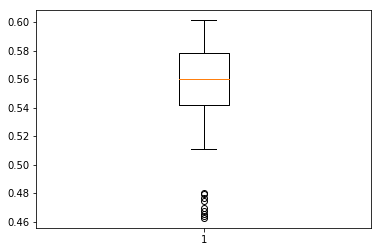

In [8]:
plt.boxplot(df['SFR_110lp_60IH_TL_H']);

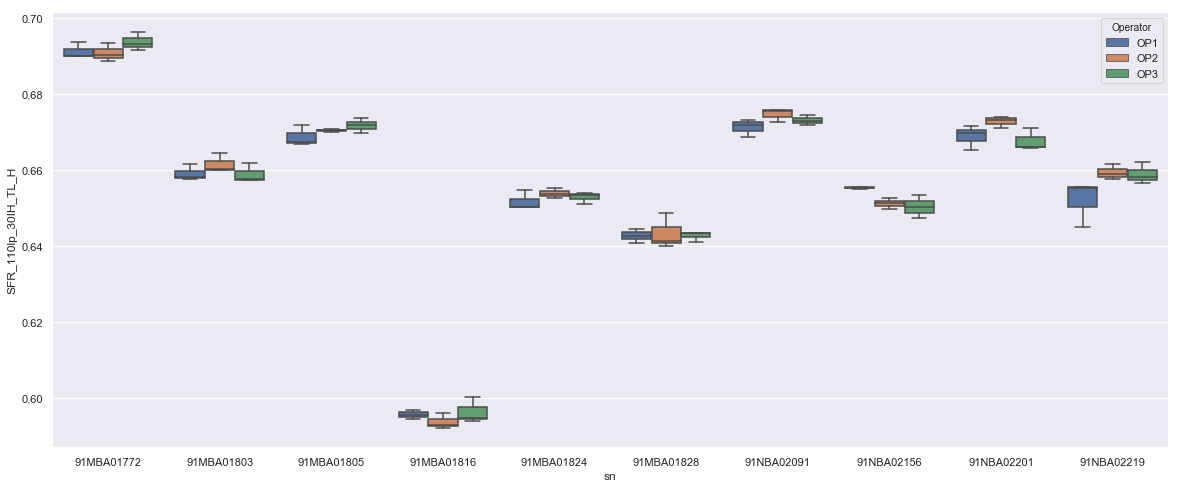

In [45]:
plt.figure(figsize=(20, 8))
sns.set()
sns.boxplot(x='sn', y='SFR_110lp_30IH_TL_H', hue='Operator', data=df, width=0.8, linewidth=1.5)

In [12]:
df2 = sns.load_dataset('iris')
df2.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


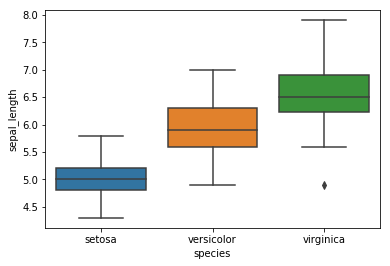

In [14]:
sns.boxplot(x='species', y='sepal_length', data=df2)

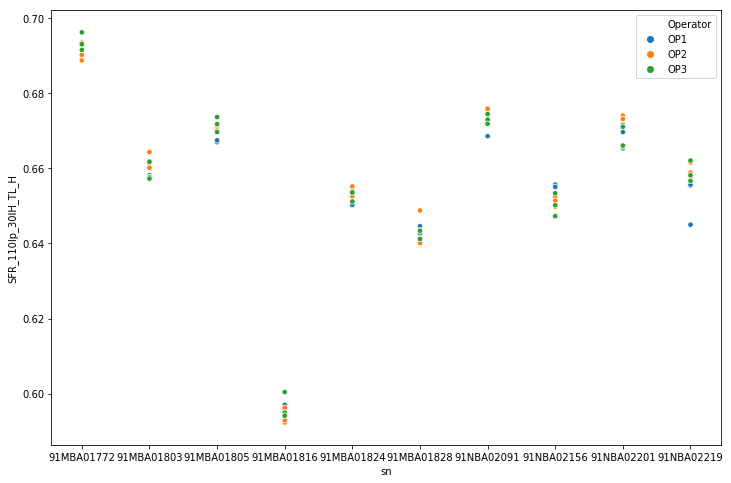

In [36]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='sn', y='SFR_110lp_30IH_TL_H', hue='Operator', data=df, s=30, y_jitter=True)

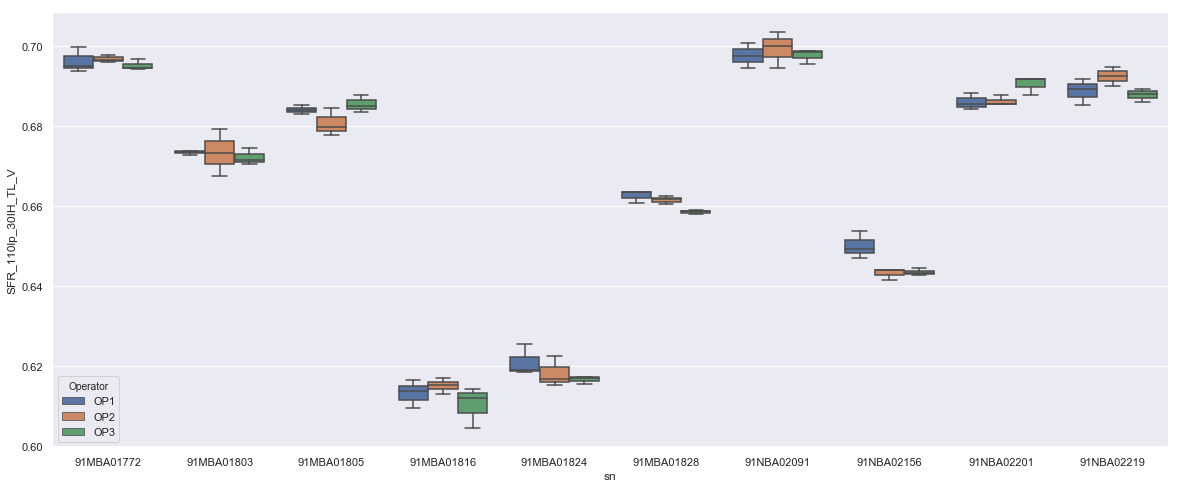

In [46]:
plt.figure(figsize=(20, 8))
sns.set()
sns.boxplot(x='sn', y='SFR_110lp_30IH_TL_V', hue='Operator', data=df, width=0.8, linewidth=1.5)